# Multi armed bandit problem
This notebook explores the multi armed bandit problem, which is one of the simplest reinforcement learning problem, which exposes the tradeoff between **exploration** and **exploitation**, which is a fundamental problem in RL.

The problem is stated as follows: \
The agent is placed in front of a row of slot machines (one armed bandits), each of them has a different reward distribution when pulling the lever. The agents goal is to maximize the overall reward. However the only information that the agent has are the immediate rewards that it receives after pulling the levers.

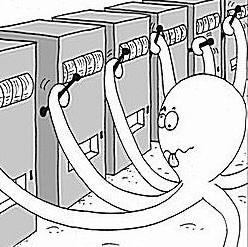

The optimal strategy would be to pull levers from the machine that have the highest expected reward, however the agent does not know the reward distribution of the machines, so it has to **explore** the machines to learn their reward distribution, but also **exploit** the machines that he thinks have the highest expected reward.

This notebook covers the chapter 2 of the book: [Reinforcement Learning: An Introduction 2nd edition by Richard S. Sutton and Andrew G. Barto](http://incompleteideas.net/sutton/book/the-book.html)

First let's implement a K-armed bandit problem, where we have K slot machines, in each of them reward is sampled from a normal distribution with different mean $q_*(a)$ and the variance of 1. This problem has only one state and k possible actions.

In [ ]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import gymnasium
from gymnasium.envs.registration import EnvCreator

plt.rcParams['figure.figsize'] = (10, 5)

DEFAULT_K = 10

class Bandit(gymnasium.Env):
    """Environment for the k-armed bandit problem"""

    def __init__(self, k_arms=DEFAULT_K, render_mode=None):
        self.k = k_arms
        self.action_space = gymnasium.spaces.Discrete(k_arms)
        self.observation_space = gymnasium.spaces.Discrete(1)
        self.render_mode = render_mode

    def step(self, action):
        if action not in self.action_space:
            raise ValueError("Invalid action")
        return 0, np.random.normal(self.q_star[action], 1), False, False, {}
    
    def reset(self, seed=None, options=None):
        np.random.seed(seed)
        self.q_star = np.random.normal(0, 1, self.k)
        return 0, {}
    
    def render(self):
        norm = np.random.normal(0, 1, size=10000)
        qs = [norm + q for q in self.q_star]

        fig, ax = plt.subplots()

        ax.violinplot(qs, showmeans=True, positions=range(self.k))
        for i, q in enumerate(self.q_star):
            ax.text(i + 0.2, q - 0.1, f"q*({i})")
        ax.axhline(0, linestyle="--")

        plt.show()
        plt.close()



class BanditCreator(EnvCreator):
    def __call__(self, k_arms=DEFAULT_K, render_mode=None) -> Bandit:
        return Bandit(k_arms=k_arms)

gymnasium.register(
    id="Bandit",
    entry_point=BanditCreator(),
    max_episode_steps=10000,
    
)

In [ ]:
env = gymnasium.make('Bandit', k_arms=10)
env.reset(seed=100)
env.render()

We pull levers by using `step` function with number of the lever. (Below we take an action *'pull lever nr **1**'* and get a reward afterwards)

In [ ]:
env.step(1)

$q_*(a)$ is the expected value of reward after taking action a: $q_*(a) = \mathbb{E}[R_t | A_t = a]$ so it is more valuable to pull levers with high q. 

The question is how to estimate q...

Our first agent will collect the rewards for each action and average them to estimate the expected reward of each action. Estimate of $q_*(s)$ is usually denoted as $Q(s)$.
In order to do that we will just need to collect the sum of rewards for each action and number of times the action was taken.

The agent usually pulls the lever with the highest estimate of the expected reward, but sometimes (with the probability of $\epsilon$ which is a hyperparameter) it will explore and pull a random lever.

In [ ]:
class EpsilonGreedyAgent:
    """Agent that chooses a random action with probability epsilon,
       otherwise the action with the highest estimated value"""

    def __init__(self, epsilon=0.1, k_arms=DEFAULT_K, initialQ=None):
        self.k = k_arms
        self.epsilon = epsilon
        if initialQ is None:
            self.initialQ = np.zeros(self.k)
        else:
            self.initialQ = initialQ
        self.reset()

    def choose_action(self):
        if np.random.random() < self.epsilon:
            return np.random.randint(self.k)
        return np.argmax(self.Q)

    def update(self, action, reward):
        """Increase the action count and update the estimated value for the chosen action"""
        self.action_count[action] += 1
        self.Q[action] += (reward - self.Q[action]) / self.action_count[action]
    
    def reset(self):
        self.Q = self.initialQ.copy()         # estimated expected rewards for each lever
        self.action_count = np.zeros(self.k)  # number of times each lever has been pulled

Let's run the experiment where we are checking different epsilon values for our epsilon-greedy algorithm. Notice that algorithm with $\epsilon = 0$ is a totally greedy algorithm.

In [ ]:
def run_episode(agent, env):
    env.reset()
    agent.reset()
    t = 0
    logs = []
    while True:
        A = agent.choose_action()
        _, R, terminated, truncated, _ = env.step(A)
        agent.update(A, R)
        logs.append((t, A, R))
        t += 1
        if terminated or truncated:
            return pd.DataFrame(logs, columns=["t", "action", "reward"])

def plot_results(results, smooth=None, hyperparameter="eps"):
    for param in results[hyperparameter].unique():
        df = results[results[hyperparameter] == param]
        y = df[['t', 'reward']].groupby("t").mean()
        if smooth:
            y = np.convolve(y.reward, np.ones(smooth) / smooth, mode='valid')
        plt.plot(y, label=param)
        plt.legend()
        plt.title("Average reward over time")
        plt.xlabel("Timestep - t")
        plt.ylabel("Average reward - R")

def run_experiment(env, agent, runs=2000, hyperparameter_name="eps", hyperparameter_list=[0.0, 0.01, 0.1]):
    """Run an experiment with 'agent' acting inside the 'environment' where
       each episode has length 'T' and the performance is averaged over 'runs' episodes
       the experiment is run for range of hyperparameters ('epsilons') and plotted
    """
    results = []
    for param in hyperparameter_list:
        setattr(agent, hyperparameter_name, param)
        agent.epsilon = param

        logs = []
        for run in range(runs):
            log = run_episode(agent, env)
            log["run"] = run
            logs.append(log)

        logs = pd.concat(logs)
        logs["eps"] = param
        results.append(logs)

    results = pd.concat(results)
    plot_results(results, smooth=10)

In [ ]:
env = gymnasium.make(
    'Bandit', max_episode_steps=2000
)

run_experiment(
    env=env,
    agent=EpsilonGreedyAgent(initialQ=np.zeros(DEFAULT_K)),
    runs=1000, # number of episodes averaged
    hyperparameter_list=[0.0, 0.01, 0.1]
)

As expected the fully greedy ($\epsilon = 0$) algorithm performs the worst, because it basically never explores the machines and sticks to the first machine that had score larger than the initialization of $q_*(a)$, which we have set to 0.

We can observe that higher value of $\epsilon$ leads to faster learning, but in the long run the algorithm with $\epsilon = 0.1$ performs the best. The higher epsilons are inferior because even after finding the best machine, they still explore a lot, which leads to lower rewards.

### Optimistic Initial values method
So far we were using Epsilon-Greedy method with initial estimates of Q set to 0 for all states, what would happen if we started with a higher (more optimistic) initial estimate of Q? 

Let's check it out.

In [ ]:
run_experiment(
    env=env,
    agent=EpsilonGreedyAgent(initialQ=np.ones(DEFAULT_K)),
    runs=1000, # number of episodes averaged
    hyperparameter_list=[0.0, 0.01, 0.1]
)

In this case it really the speed of convergence agent was more eager to **explore** the states just because he was more optimistic about the rewards. However in the long run the performance is the same, because the agent will eventually learn the true rewards and the initial estimates will not matter anymore.

This method allows us to supply the agent with some prior knowledge about environment it might be difficult to use in practice in many cases, but its interesting to think about - it shows us that initial values sometimes matter.


## Nonstationary problem
For now the problem was stationary, meaning that the reward distribution of the machines did not change over time. However in the real world the reward distributions sometimes change over time. Our current algorithm is quite inefficient in this case as it averages the rewards over entire history, which leads to slow adaptation to the new reward distributions (the longer the algorithm is running the more difficult it is to change the average reward as more terms influence itEpsilonGreedyAgent).

Below is an implementation of Nonstationary Bandit problem, which on every step changes the reward distributions of all machines by adding a random number to their $q_*(a)$ values.


In [ ]:
class NonstationaryBandit(Bandit):
    """Nonstationary k-armed bandit environment"""

    def __init__(self, k_arms=DEFAULT_K, step_size=0.01):
        super().__init__(k_arms)
        self.step_size = step_size  # random walk step size

    def step(self, action):
        reward = super().step(action)
        self.q_star += np.random.normal(0, self.step_size, self.k)
        return reward


class BanditCreator(EnvCreator):
    def __call__(self, k_arms=DEFAULT_K, stationary=True, step_size=0.1) -> Bandit:
        if stationary:
            return Bandit(k_arms=k_arms)
        else:
            return NonstationaryBandit(k_arms=k_arms, step_size=step_size)

gymnasium.register(
    id="Bandit",
    entry_point=BanditCreator(),
    max_episode_steps=10000,
)

In [ ]:
env = gymnasium.make("Bandit", stationary=False)

env.reset(seed=42)
print("At the beginning")
env.render()
for _ in range(500): env.step(0)
print("After 500 actions")
env.render()
for _ in range(500): env.step(0)
print("After 1000 actions")
env.render()

Let's see if our algorithm still works in this case.

In [ ]:
env = gymnasium.make(
    'Bandit',
    stationary=False,
    max_episode_steps=6000
)

run_experiment(
    env=env,
    agent=EpsilonGreedyAgent(),
    runs=500,
)

It seems that the algorithm does ok job, but let's try to develop a better one.

### Epsilon Greedy Agent with a constant step size
In nonstationary problems we should give more weight to the recent rewards, because the older rewards are less relevant to the current reward distribution. We can achieve this by using a constant step size $\alpha$ in our update rule. The update rule is then defined as follows:
$Q_{n+1} = Q_n + \alpha(R_n - Q_n)$

Where $Q_n$ is the estimated value of the action a at time n, and $R_n$ is the reward received at time n. 

In [ ]:
class EpsilonGreedyAgentAlpha(EpsilonGreedyAgent):
    """Agent that chooses a random action with probability epsilon,
       otherwise the action with the highest estimated value"""

    def __init__(self, epsilon=0.1, k_arms=DEFAULT_K, step_size=0.1):
        super().__init__(epsilon, k_arms)
        self.step_size = step_size  # learning rate / alpha

    def update(self, action, reward):
        """Update the estimated value for the chosen action"""
        self.Q[action] += self.step_size * (reward - self.Q[action])

In [ ]:
env = gymnasium.make(
    'Bandit',
    stationary=False,
    max_episode_steps=6000
)

run_experiment(
    env=env,
    agent=EpsilonGreedyAgentAlpha(step_size=0.1), # step size can be though of as learning rate
    runs = 500
)

As you can see this agent obtained better results than the previous one, especially in the latter timesteps.


## Upper-Confidence-Bound Action selection (UCB method)
A goal of exploration can be conveyed in two words: *Reducing uncertaintity*, this is true as if we were just taking one action then we would be very uncertain about if it is really the best action on the other hand if we were sampling every action equally likely we could be quite certain about which of them is the best. 

Let's try to define some uncertaintity measure, we can say that every time we choose some action, the uncertaintity about it's expected reward decreases \
Consider function  $\frac{1}{N_t(a)}$, let N be number of times action a was chosen at timestep t, you can clearly see that the more times we choose action the lower its uncertaintity factor. \
However for mathematical reasons it is better to use as an uncertaintity factor a function like $U(a) = $c\sqrt{\frac{ln\ t}{N_t(a)}}$, the logarithm is there to stop the term from going to zero too fast, square root makes the factor resemble more the sample Error, and c is the importance factor that we assign to U, so for c the U factor is more aggressive and has more impact.

### Task
Try to implement UCB agent and run some experiments on a nonstationary bandit problem:

In [ ]:
class UCB_Agent:
    """Agent that keeps track of uncertaintity of its estimates about the actions,
       chooses the actions that have the highest sum of estimate and uncertaintity factor
    """

    def __init__(self, c=2, k_arms=DEFAULT_K, initialQ=None):
        self.k = k_arms
        self.c = c
        if initialQ is None:
            self.initialQ = np.zeros(self.k)
        else:
            self.initialQ = initialQ
        self.reset()

    def choose_action(self):
        """Chose the action that has the highest Q(a) + U(a)"""
        # TODO

    def update(self, action, reward):
        """Increase the action count and update the estimated value for the chosen action"""
        self.N[action] += 1
        self.Q[action] += (reward - self.Q[action]) / self.N[action]
    
    def reset(self):
        self.Q = self.initialQ.copy()        # estimated expected rewards for each lever
        self.N = np.zeros(self.k)            # number of times each lever has been pulled
        self.t = 0

env = gymnasium.make("Bandit", max_episode_steps=2000)
agent = UCB_Agent()

run_experiment(env,agent,hyperparameter_name="c", hyperparameter_list=[2])
run_experiment(env,EpsilonGreedyAgent(),hyperparameter_list=[0.01, 0.1])